Networks and Word Vectors with MeSH Labels
==========================================

In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ast
import json
import itertools

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from datetime import datetime
from itertools import zip_longest
from matplotlib.ticker import NullFormatter

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool

In [3]:
pd.options.display.max_columns = 99

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
%matplotlib inline

#NB Open a standard set of directories
sep = os.sep
#Paths
#Get the top path
top_path = os.path.dirname(os.getcwd())
#Create the path for external data
ext_data = os.path.join(top_path,'data{s}external{s}'.format(s=sep))
#Raw path (for html downloads)
raw_data = os.path.join(top_path,'data{s}raw{s}'.format(s=sep))
#And external data
proc_data = os.path.join(top_path,'data{s}processed{s}'.format(s=sep))
#And path for figures
fig_path = os.path.join(top_path,'reports{s}figures{s}'.format(s=sep))

#Get date for saving files
today = datetime.utcnow()
today_str = "_".join([str(x) for x in [today.month, today.day, today.year]])

In [6]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [7]:
def column_to_list(df, c):
    return [ast.literal_eval(i) for i in df[c]]

In [8]:
def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [9]:
gdb_df = pd.read_csv(proc_data + 'gdb_5_25_2018.csv')

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,5,7,10,11,12,13,14,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
gdb_df.head()

,GH User ID,GDB Dataset ID,Source ID,Start Date,Status,GH User Creation Date,Description,Funding,Row ID,Currency,CB Category Group List,GH User Type,CB Number of Employees,CB Category List,CB Role,End Date,GH Valid Description,Name,administrative_area_level_1,administrative_area_level_2,lng,lat,country,doc_id,original_phrases,mesh_labels,pub_med_uids,mesh_cuis,mesh_duis,mesh_term_token_start_idx,mesh_term_token_end_idx
0,NaN,gtr,GDB,2009-04-01 00:00:00,Closed,NaN,The past decade has seen a renaissance in acce...,2313330.0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/00C9...,GBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom,0,"['the UK', 'physics', 'Physics', 'neutron', 'D...","['United Kingdom', 'Physics', 'Physics', 'Neut...",[],"['C0041700', 'C0031837', 'C0031837', 'C0027946...","['D006113', 'D010825', 'D010825', 'D009502', '...","[65, 230, 510, 932, 1001, 1174, 1192, 1206, 13...","[71, 237, 517, 939, 1008, 1181, 1196, 1212, 13..."
1,NaN,gtr,GDB,2009-10-01 00:00:00,Closed,NaN,Humans and animals are made up of millions of ...,1520860.0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/00E4...,GBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom,1,"['Humans', 'animals', 'plasma membrane', 'phos...","['Humans', 'Animals', 'Cell Membrane', 'Phosph...",[],"['C0086418', 'C0003062', 'C0007603', 'C0031676...","['D006801', 'D000818', 'D002462', 'D010743', '...","[0, 11, 112, 136, 167, 336, 370, 391, 460, 558...","[6, 18, 127, 149, 178, 351, 383, 406, 470, 571..."
2,NaN,gtr,GDB,2013-01-01 00:00:00,Closed,NaN,Our immune system is vital to protect us from ...,488548.0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/011C...,GBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom,2,"['immune system', 'bacterial', 'innate immunit...","['Immune System', 'Bacteria', 'Immunity, Innat...",[],"['C0020962', 'C0004611', 'C0020969', 'C0020962...","['D007107', 'D001419', 'D007113', 'D007107', '...","[4, 59, 266, 388, 518, 581, 617, 787, 864, 880...","[17, 68, 281, 401, 528, 589, 627, 793, 870, 88..."
3,NaN,gtr,GDB,2007-12-01 00:00:00,Closed,NaN,Nerve cells communicate through electrical sig...,414489.0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/0120...,GBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom,3,"['Nerve cells', 'action potentials', 'ion chan...","['Neurons', 'Action Potentials', 'Ion Channels...",[],"['C0027882', 'C0001272', 'C0022009', 'C0007603...","['D009474', 'D000200', 'D007473', 'D002462', '...","[0, 58, 100, 157, 184, 242, 316, 322, 421, 491...","[11, 75, 112, 171, 196, 246, 319, 324, 438, 50..."
4,NaN,gtr,GDB,2005-09-01 00:00:00,Closed,NaN,Childhood overweight and obesity is rising rap...,156174.0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/0158...,GBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University College London,England,Greater London,-0.132718,51.524469,United Kingdom,4,"['Childhood overweight', 'the UK', 'Cohort Stu...","['Pediatric Obesity', 'United Kingdom', 'Cohor...",[],"['C2362324', 'C0041700', 'C0009247', 'C0008059...","['D063766', 'D006113', 'D015331', 'D002648', '...","[0, 58, 214, 256, 256, 300, 389, 411, 432, 628...","[20, 64, 226, 264, 264, 306, 406, 415, 441, 64..."


In [11]:
gdb_df = gdb_df[gdb_df['Source ID'] != 'GitHub']
gdb_df['Description'][pd.isnull(gdb_df['Description'])] = ''

## MeSH Label Exploration

In [12]:
mesh_labels = [ast.literal_eval(ml) for ml in gdb_df['mesh_labels']]

In [13]:
mesh_label_counts = Counter(flatten(mesh_labels))

In [14]:
def print_counter_extremes(counter, n=20, low_pass=5, order_low_counts=False):
    most_common = counter.most_common(n)
    low_counts = {k: v for k, v in counter.items() if v <= low_pass}
    low_count_keys_n = list(itertools.islice(low_counts, n))
    low_counts_n = [(k, low_counts[k]) for k in low_count_keys_n]
        
    max_len_high = 0
    max_len_low = 0
    for high, low in zip(most_common, low_counts_n):
        if len(high[0]) > max_len_high:
            max_len_high = len(high[0])
        if len(low[0]) > max_len_low:
            max_len_low = len(low[0])
        
    print('{:<{max_len_high}}\t{}\t{:{max_len_low}}\t{}\n'.format('Label (Common)', 'Count', 'Label (Uncommon)', 'Count',
                                                                  max_len_high=max_len_high + 2,
                                                                  max_len_low=max_len_low + 2))
    for high, low in zip(most_common, low_counts_n):
        print('{:<{max_len_high}}\t{}\t{:{max_len_low}}\t{}'.format(high[0], high[1], low[0], low[1],
                                                         max_len_high=max_len_high + 2,
                                                         max_len_low=max_len_low + 2))

In [15]:
print_counter_extremes(mesh_label_counts, 30)

Label (Common)                	Count	Label (Uncommon)                                     	Count

Humans                        	91917	UBB protein, human                                   	1
Students                      	60345	eculizumab                                           	3
Animals                       	36109	Apoptosis Regulatory Proteins                        	3
Research                      	28194	Hirschsprung Disease                                 	2
Goals                         	26950	Tracheostomy                                         	3
Universities                  	24933	Blood-Nerve Barrier                                  	1
Research Personnel            	20191	Chloride Channels                                    	1
United States                 	17680	Hepatorenal Syndrome                                 	3
Female                        	17213	In Vivo Dosimetry                                    	3
Brain                         	16057	Amino Acid Transport System 

- Zip together mesh_labels and codes
- Get unique combinations as list of tuples (of tuples)

In [16]:
mesh_duis = [ast.literal_eval(ml) for ml in gdb_df['mesh_duis']]

In [17]:
mesh_label_dui_map = {}

for labels, duis in zip(mesh_labels, mesh_duis):
    for label, dui in zip(labels, duis):
        if label not in mesh_label_dui_map:
            mesh_label_dui_map[label] = dui

In [18]:
with open(proc_data + 'mesh_descriptions_5_29_2018.json', 'r') as f:
    mesh_terms = json.load(f)

In [19]:
dui_tree_number_map = {}

for descriptor in mesh_terms['DescriptorRecordSet']['DescriptorRecord']:
    tree_number = descriptor.get('TreeNumberList')
    if tree_number is not None:
        tree_number = tree_number.get('TreeNumber')
    if isinstance(tree_number, list):
        dui_tree_number_map[descriptor['DescriptorUI']] = tree_number
    else:
        dui_tree_number_map[descriptor['DescriptorUI']] = [tree_number]

In [20]:
tree_level_0_map = {
    'A': 'anatomy',
    'B': 'organisms',
    'C': 'diseases',
    'D': 'chemicals and drugs',
    'E': 'analytical, diagnostic, and therapeutic techniques, and equipment',
    'F': 'psychiatry and psychology',
    'G': 'phenomena and processes',
    'H': 'disciplines and occupations',
    'I': 'anthropology, education, sociology, and social phenomena',
    'J': 'technology, industry, and agriculture',
    'K': 'humanities',
    'L': 'information science',
    'M': 'named groups',
    'N': 'health care',
    'V': 'publication characteristics',
    'Z': 'geographicals'
}

In [21]:
tree_level_1_map = {}

for descriptor in mesh_terms['DescriptorRecordSet']['DescriptorRecord']:
    tree_number = descriptor.get('TreeNumberList')
    descriptor_name = descriptor.get('DescriptorName')
    descriptor_name = descriptor_name['String']
    if tree_number is not None:
        tree_number = tree_number.get('TreeNumber')
        if isinstance(tree_number, str):
            if len(tree_number.split('.')) == 1:
                tree_level_1_map[tree_number] = descriptor_name

In [22]:
mesh_label_nodes = list(mesh_label_counts.keys())

In [23]:
n_mesh_labels = len(flatten(mesh_labels))

- Add nodes
    - count: total count
    - count_normalised: normalised count
    - mesh_tree_codes: list of mesh groups
    - edge_count: number unique coocurrences

In [24]:
def map_tree_group(label, label_dui_map, dui_tree_number_map, tree_map, level=1):
    dui = label_dui_map.get(label)
    groups = []
    if dui is not None:
        tree_numbers = dui_tree_number_map.get(dui)
        if tree_numbers is not None:
            for tn in tree_numbers:
                if tn is not None:
                    tn = tn.split('.')
                    if level == 0:
                        tn = tn[0][0]
                    elif level == 1:
                        tn = tn[0]
                    else:
                        tn = '.'.join(tn[:level - 1])
                    group = tree_map.get(tn)
                    if group is not None:
                        groups.append(group)
    if len(groups) > 0:
        return list(set(groups))
    else:
        return ['Other']

In [25]:
graph_mesh_labels = nx.Graph()

In [26]:
for mln in mesh_label_nodes:
    count = mesh_label_counts[mln]
    graph_mesh_labels.add_node(
        mln,
        count=count,
        count_normalised=count / n_mesh_labels,
        groups=map_tree_group(
            mln, 
            mesh_label_dui_map, 
            dui_tree_number_map, 
            tree_level_1_map
        )
    )

- Add edges
    - weight_absolute: number of coocurring documents
    - jaccard_similarity: jaccard index of terms
    - association_strength: association strength score of terms
    
Flatten list of all combinations. Create counter. Build edges based on Counter and also calculated adjusted edge weights.

In [27]:
mesh_label_coocurrences = []
for ml in mesh_labels:
    mesh_label_doc = list(itertools.combinations(set(ml), r=2))
    mesh_label_doc = [tuple(sorted(mld)) for mld in mesh_label_doc]
    mesh_label_coocurrences.append(mesh_label_doc)

mesh_label_edges = Counter(flatten(mesh_label_coocurrences))

In [28]:
n_edges = len(flatten(mesh_label_coocurrences))

In [29]:
mesh_coocurrence_counts = defaultdict(dict)

for ml, c in mesh_label_edges.items():
    n0 = ml[0]
    n1 = ml[1]
    mesh_coocurrence_counts[n0][n1] = c
    mesh_coocurrence_counts[n1][n0] = c

In [30]:
mesh_edge_counts = {}
for ml, co in mesh_coocurrence_counts.items():
    edge_count = sum([n for n in co.values()])
    mesh_edge_counts[ml] = edge_count

In [31]:
def jaccard_similarity(c0, c1, n):
    return n / (c0 + c1 - n)

In [32]:
def association_strength(term_0, term_1, n):
    return (2 * n_edges * n) / (mesh_edge_counts[term_0] * mesh_edge_counts[term_1])

In [33]:
for edge, count in mesh_label_edges.items():
    node_0 = edge[0]
    node_1 = edge[1]
    graph_mesh_labels.add_edge(node_0, node_1,
                               coocurrences_absolute=count,
                               jaccard_similarity=jaccard_similarity(mesh_label_counts[node_0],
                                                                       mesh_label_counts[node_1],
                                                                       count),
                               association_strength=association_strength(node_0,
                                                                         node_1,
                                                                         count))

In [34]:
print('{:<30}\t{:<20}\t{:30}\t{:<15}\t{:<15}\t{}\t{}\n'.format(
    'Node 0', 'Count Node 0', 'Node 1', 'Count Node 1', 'Cooccurences',
    'Jaccard Similarity', 'Association Strength'))

for l, n in mesh_label_edges.most_common(20):
    c0 = mesh_label_counts[l[0]]
    c1 = mesh_label_counts[l[1]]
    j = n / (c0 + c1 - n)
    a = association_strength(l[0], l[1], n)
    print('{:<30}\t{:<20}\t{:30}\t{:<15}\t{:<15}\t{:.2f}\t{:20.2f}'.format(l[0], c0, l[1], c1, n, j, a))

Node 0                        	Count Node 0        	Node 1                        	Count Node 1   	Cooccurences   	Jaccard Similarity	Association Strength

Goals                         	26950               	Humans                        	91917          	12647          	0.12	                1.12
Animals                       	36109               	Humans                        	91917          	10638          	0.09	                0.92
Female                        	17213               	Humans                        	91917          	9724           	0.10	                1.38
Child                         	12451               	Humans                        	91917          	9047           	0.09	                1.76
Humans                        	91917               	Students                      	60345          	7960           	0.06	                0.94
Humans                        	91917               	United States                 	17680          	7573           	0.07	                1.1

In [40]:
import spacy

In [50]:
nlp = spacy.load('en_core_web_sm')

In [51]:
# nlp.remove_pipe('ner')

In [52]:
with open('../data/external/en_ranknl_long.txt', 'r') as f:
    text = f.read()
stop_words = text.split('\n')

In [53]:
for stop in stop_words:
    nlp.vocab[stop].is_stop = True
    nlp.vocab[stop.title()].is_stop = True
    nlp.vocab[stop.upper()].is_stop = True

In [54]:
import textacy

In [55]:
meta = gdb_df[['doc_id', 'mesh_labels', 'country']].to_dict(orient='records')

In [56]:
%time corpus_descriptions = textacy.Corpus(lang=nlp, texts=descriptions, metadatas=meta)

CPU times: user 2h 17min 4s, sys: 37min 1s, total: 2h 54min 6s
Wall time: 2h 48min


In [58]:
doc_lengths = [len(td.spacy_doc) for td in corpus_descriptions]

In [60]:
mesh_label_doc_lengths = [len(ml) for ml in mesh_labels]

In [61]:
mesh_label_unique_doc_lengths = [len(list(set(ml))) for ml in mesh_labels]

In [ ]:
def scatter_histograms(x, y, normed=True):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(14, 8))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    axScatter.scatter(x, y, alpha=0.05)

    # now determine nice limits by hand:
    xbinwidth = 20
    ybinwidth = 1
    xmax = np.max(x)
    ymax = np.max(y)

    xlim = (int(xmax/xbinwidth) + 1) * xbinwidth
    ylim = (int(ymax/ybinwidth) + 1) * ybinwidth

    axScatter.set_xlim((0, xlim))
    axScatter.set_ylim((-0, ylim))
    axScatter.set_xlabel('Number of Tokens')
    axScatter.set_ylabel('Number of MeSH Labels')

    bins_x = np.arange(0, xlim + xbinwidth, xbinwidth)
    bins_y = np.arange(0, ylim + ybinwidth, ybinwidth)

#     axHistx.hist(x, bins=xbins, normed=True)
    ax_hist_x_cum = axHistx.twinx()
    
    hist_counts_x, bin_edges_x = np.histogram (x, bins=bins_x, normed=normed)
    
    cdf_x = np.cumsum(hist_counts_x)
    
    axHisty.hist(y, bins=ybins, orientation='horizontal', normed=True)

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    
    ax_hist_x_cum.hist(x, bins=xbins, histtype='step',
                       normed=True, cumulative=True, color='orange', linewidth=2)
    ax_hist_x_cum.set_ylabel('Cumulative', color='orange')
    ax_hist_x_cum.tick_params('y', colors='orange')
    
    ax_hist_y_cum = axHisty.twiny()
    ax_hist_y_cum.hist(y, bins=ybins, orientation='horizontal', histtype='step',
                       normed=True, cumulative=True, color='orange', linewidth=2)
    ax_hist_y_cum.set_xlabel('Cumulative', color='orange')
    ax_hist_y_cum.tick_params('x', colors='orange')

    axHistx.set_title('Document Lengths vs. Number of Unique MeSH Labels Identified')

plt.show()

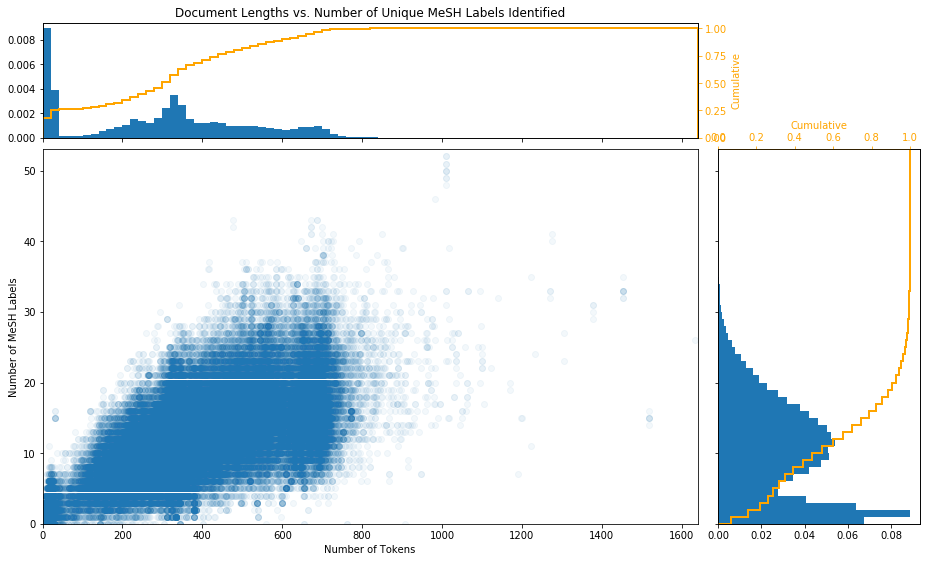

In [63]:
nullfmt = NullFormatter()         # no labels

x = doc_lengths
y = mesh_label_unique_doc_lengths

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(14, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.scatter(x, y, alpha=0.05)

# now determine nice limits by hand:
xbinwidth = 20
ybinwidth = 1
xmax = np.max(x)
ymax = np.max(y)

xlim = (int(xmax/xbinwidth) + 1) * xbinwidth
ylim = (int(ymax/ybinwidth) + 1) * ybinwidth

axScatter.set_xlim((0, xlim))
axScatter.set_ylim((-0, ylim))
axScatter.set_xlabel('Number of Tokens')
axScatter.set_ylabel('Number of MeSH Labels')

xbins = np.arange(0, xlim + xbinwidth, xbinwidth)
ybins = np.arange(0, ylim + ybinwidth, ybinwidth)

axHistx.hist(x, bins=xbins, normed=True)
ax_hist_x_cum = axHistx.twinx()
ax_hist_x_cum.hist(x, bins=xbins, histtype='step',
                   normed=True, cumulative=True, color='orange', linewidth=2)
ax_hist_x_cum.set_ylabel('Cumulative', color='orange')
ax_hist_x_cum.tick_params('y', colors='orange')

axHisty.hist(y, bins=ybins, orientation='horizontal', normed=True)
ax_hist_y_cum = axHisty.twiny()
ax_hist_y_cum.hist(y, bins=ybins, orientation='horizontal', histtype='step',
                   normed=True, cumulative=True, color='orange', linewidth=2)
ax_hist_y_cum.set_xlabel('Cumulative', color='orange')
ax_hist_y_cum.tick_params('x', colors='orange')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axHistx.set_title('Document Lengths vs. Number of Unique MeSH Labels Identified')

plt.show()

In [67]:
edge_association_strengths = []
edge_counts = []
for edge, count in mesh_label_edges.items():
    edge_association_strengths.append(association_strength(edge[0], edge[1], mesh_label_edges[edge]))
    edge_counts.append(count)

In [68]:
edge_association_strengths_log = np.log(edge_association_strengths)
edge_counts_log = np.log(edge_counts)

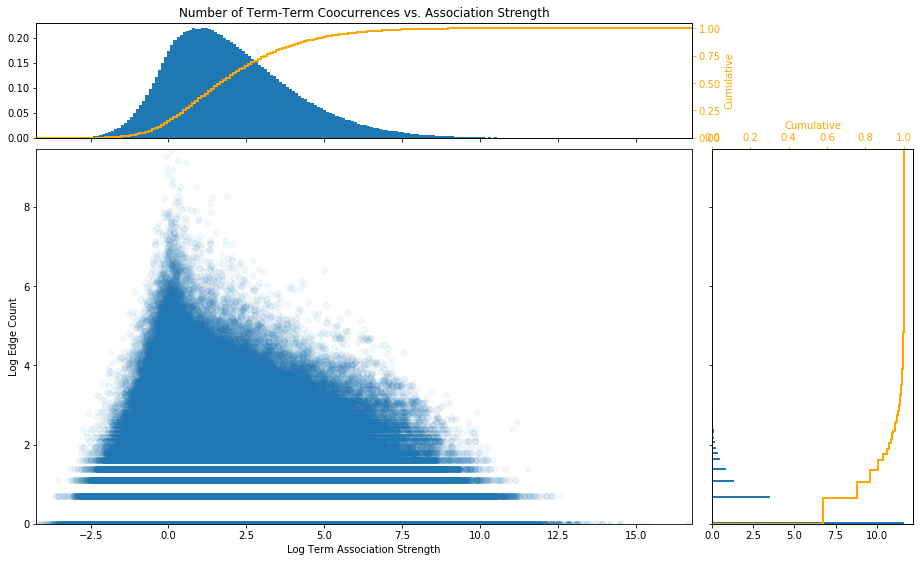

In [66]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(14, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.scatter(edge_association_strengths_log, edge_counts_log, alpha=0.05)

# now determine nice limits by hand:
xbinwidth = 0.1
ybinwidth = 0.05
xmax = np.max(edge_association_strengths_log)
xmin = np.min(edge_association_strengths_log)
ymax = np.max(edge_counts_log)
ymin = np.min(edge_counts_log)

xlim = (int(xmax/xbinwidth) + 1) * xbinwidth
ylim = (int(ymax/ybinwidth) + 1) * ybinwidth

axScatter.set_xlim((xmin, xlim))
axScatter.set_ylim((ymin, ylim))
axScatter.set_xlabel('Log Term Association Strength')
axScatter.set_ylabel('Log Edge Count')

xbins = np.arange(xmin, xlim + xbinwidth, xbinwidth)
ybins = np.arange(ymin, ylim + ybinwidth, ybinwidth)

axHistx.hist(edge_association_strengths_log, bins=xbins, normed=True)
ax_hist_x_cum = axHistx.twinx()
ax_hist_x_cum.hist(edge_association_strengths_log, bins=xbins, histtype='step',
                   normed=True, cumulative=True, color='orange', linewidth=2)
ax_hist_x_cum.set_ylabel('Cumulative', color='orange')
ax_hist_x_cum.tick_params('y', colors='orange')

axHisty.hist(edge_counts_log, bins=ybins, orientation='horizontal', normed=True)
ax_hist_y_cum = axHisty.twiny()
ax_hist_y_cum.hist(edge_counts_log, bins=ybins, orientation='horizontal', histtype='step',
                   normed=True, cumulative=True, color='orange', linewidth=2)
ax_hist_y_cum.set_xlabel('Cumulative', color='orange')
ax_hist_y_cum.tick_params('x', colors='orange')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axHistx.set_title('Number of Term-Term Coocurrences vs. Association Strength')

plt.show()

In [69]:
edge_jaccard_similarities = []
for edge, count in mesh_label_edges.items():
    edge_jaccard_similarities.append(jaccard_similarity(mesh_label_counts[edge[0]], mesh_label_counts[edge[1]], count))

In [81]:
edge_jaccard_similarities_log = np.log(edge_jaccard_similarities)

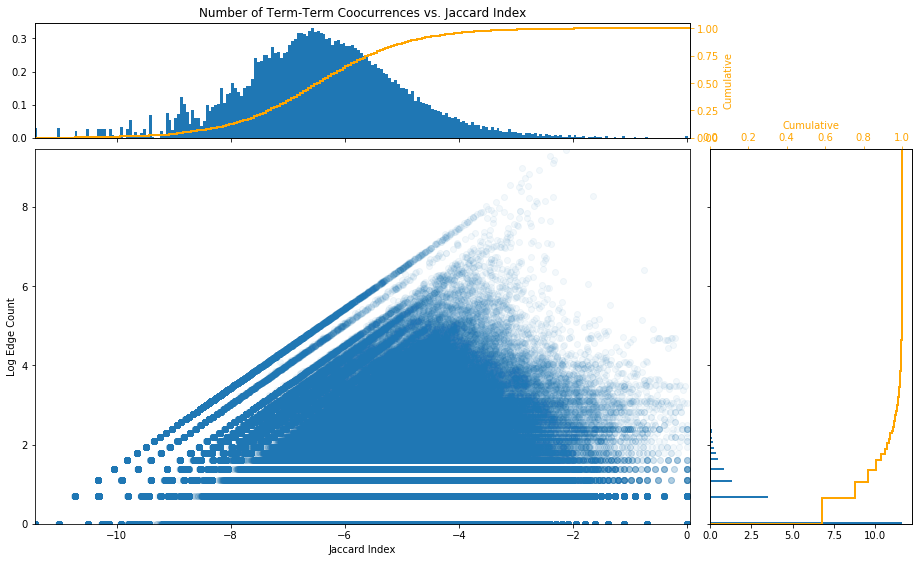

In [84]:
nullfmt = NullFormatter()         # no labels

y = edge_counts_log
x = edge_jaccard_similarities_log

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(14, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.scatter(x, y, alpha=0.05)

# now determine nice limits by hand:
xbinwidth = 0.05
ybinwidth = 0.05
xmax = np.max(x)
xmin = np.min(x)
ymax = np.max(y)
ymin = np.min(y)

xlim = (int(xmax/xbinwidth) + 1) * xbinwidth
ylim = (int(ymax/ybinwidth) + 1) * ybinwidth

axScatter.set_xlim((xmin, xlim))
axScatter.set_ylim((ymin, ylim))
axScatter.set_xlabel('Jaccard Index')
axScatter.set_ylabel('Log Edge Count')

xbins = np.arange(xmin, xlim + xbinwidth, xbinwidth)
ybins = np.arange(ymin, ylim + ybinwidth, ybinwidth)

axHistx.hist(x, bins=xbins, normed=True)
ax_hist_x_cum = axHistx.twinx()
ax_hist_x_cum.hist(x, bins=xbins, histtype='step',
                   normed=True, cumulative=True, color='orange', linewidth=2)
ax_hist_x_cum.set_ylabel('Cumulative', color='orange')
ax_hist_x_cum.tick_params('y', colors='orange')

axHisty.hist(y, bins=ybins, orientation='horizontal', normed=True)
ax_hist_y_cum = axHisty.twiny()
ax_hist_y_cum.hist(y, bins=ybins, orientation='horizontal', histtype='step',
                   normed=True, cumulative=True, color='orange', linewidth=2)
ax_hist_y_cum.set_xlabel('Cumulative', color='orange')
ax_hist_y_cum.tick_params('x', colors='orange')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axHistx.set_title('Number of Term-Term Coocurrences vs. Jaccard Index')

plt.show()

#### Document Level Stats

In [94]:
mean_doc_association_strength = []
stddev_doc_association_strength = []
for mlc in mesh_label_coocurrences:
    association_strengths = [association_strength(edge[0], edge[1], mesh_label_edges[edge]) for edge in mlc]
    if len(association_strengths) > 0:
        mean_doc_association_strength.append(np.mean(association_strengths))
        stddev_doc_association_strength.append(np.std(association_strengths))

In [109]:
stddev_doc_association_strength_log = np.log(stddev_doc_association_strength)
stddev_doc_association_strength_log = [a for a in stddev_doc_association_strength_log if ~np.isinf(a)]
mean_doc_association_strength_log = np.log(mean_doc_association_strength)
mean_doc_association_strength_log = [a for a in mean_doc_association_strength_log if ~np.isinf(a)]

/Users/grichardson/miniconda3/envs/rwjf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


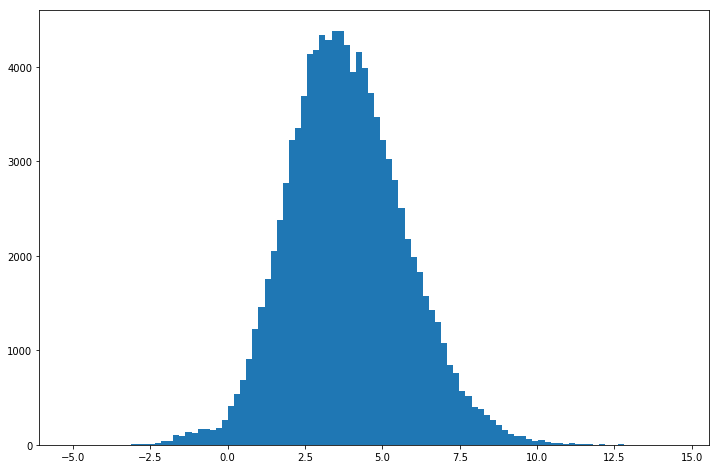

In [115]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.hist(stddev_doc_association_strength_log, bins=100)
plt.show()

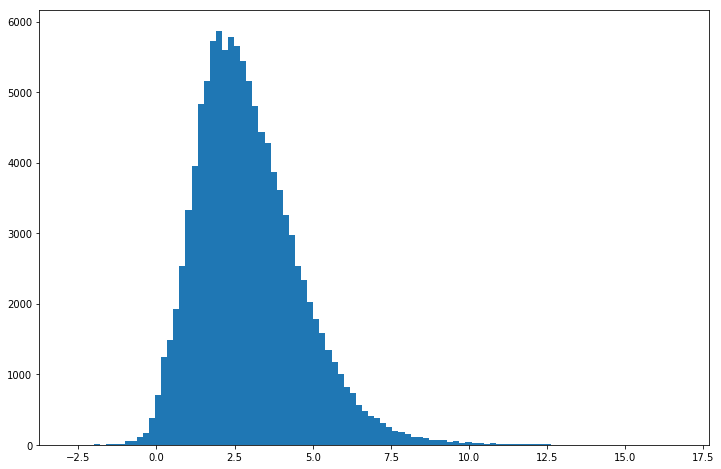

In [116]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.hist(mean_doc_association_strength_log, bins=100)
plt.show()

In [ ]:
plt.hist(stddev_doc_association_strength_log)

In [ ]:
for edge, count in mesh_label_edges.items():

In [573]:
mean_doc_association_strength = [0 if pd.isnull(a) else a for a in mean_doc_association_strength ]